In [2]:
import os
import random
from matplotlib import pyplot as plt
from PIL import Image
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import resize
# pip install pytorch_msssim opensimplex
from pytorch_msssim import SSIM
from torchvision.models.feature_extraction import create_feature_extractor
from opensimplex import OpenSimplex

base_healthy_path = "/kaggle/input/ixit2-slices/image slice-T2/"
sick_training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


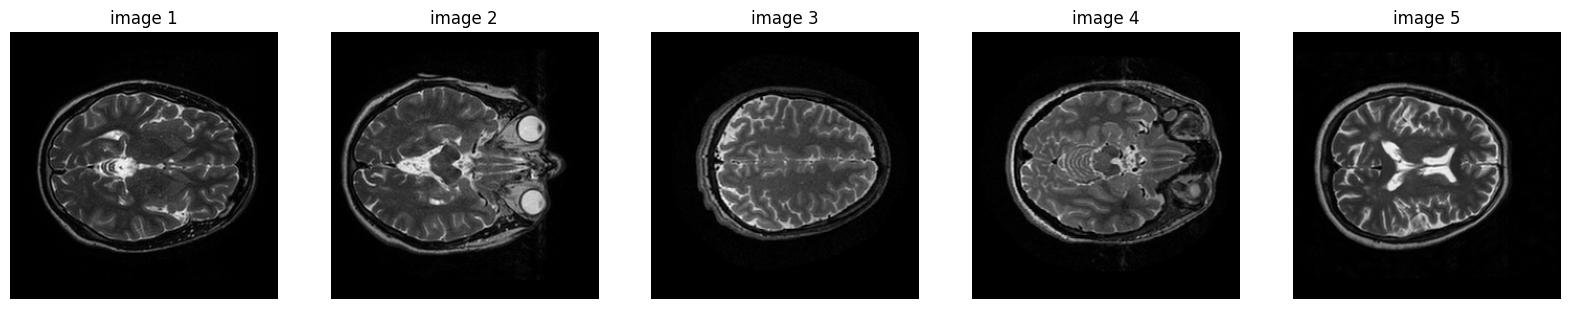

In [2]:
subfolders = [os.path.join(base_healthy_path, folder) for folder in os.listdir(base_healthy_path) if os.path.isdir(os.path.join(base_healthy_path, folder))]

random.seed(42)
random_samples = []
for _ in range(5):
    random_folder = random.choice(subfolders)
    images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.endswith('.png')]
    if images:
        random_samples.append(random.choice(images))

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
i = 0
for ax, img_path in zip(axes, random_samples):
    i += 1
    image = Image.open(img_path)
    ax.imshow(image, cmap='gray')
    ax.set_title("image " + str(i))
    ax.axis('off')
plt.show()

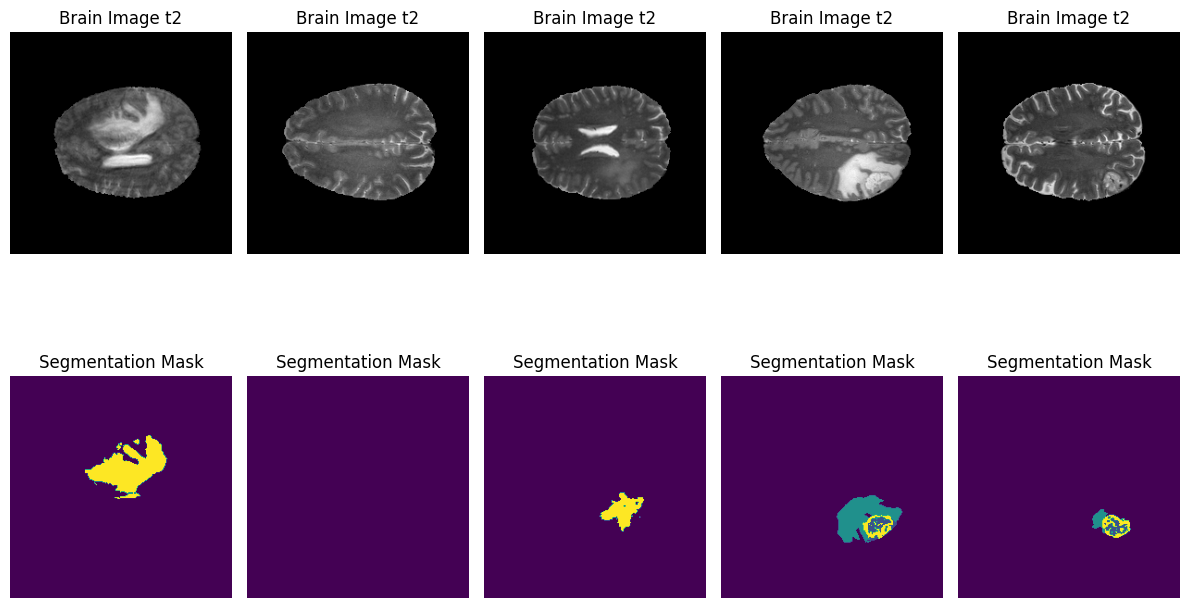

In [3]:
folders = [os.path.join(sick_training_path, folder) for folder in os.listdir(sick_training_path) if os.path.isdir(os.path.join(sick_training_path, folder))]

fig, axes = plt.subplots(2, 5, figsize=(12, 8))
for i, folder in enumerate(sorted(folders)[:5]):
    folder_name = os.path.basename(folder)
    t2_path = os.path.join(folder, f"{folder_name}_t2.nii")
    seg_path = os.path.join(folder, f"{folder_name}_seg.nii")
    
    t2_data = nib.load(t2_path).get_fdata()
    seg_data = nib.load(seg_path).get_fdata()

    t2_slice = t2_data[:, :, t2_data.shape[0]//2-25]
    seg_slice = seg_data[:, :, seg_data.shape[0]//2-25]

    axes[0, i].imshow(t2_slice, cmap='gray')
    axes[0, i].set_title("Brain Image t2")
    axes[0, i].axis('off')

    axes[1, i].imshow(seg_slice)
    axes[1, i].set_title("Segmentation Mask")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
class IXIT2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, folder, img)
            for folder in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, folder))
            for img in os.listdir(os.path.join(root_dir, folder))
            if img.endswith(".png")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")
    
        if self.transform:
            image = self.transform(image)
              
        return image.to(device)

## VAE

In [5]:
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 256x256 -> 128x128
            nn.ReLU(),
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(),
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 128 * 32 * 32)
        
        self.decoder_deconv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
        )
        
        self.decoder_deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
        )  
        
        self.decoder_deconv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 128x128 -> 256x256
            nn.Sigmoid(),
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x1 = self.encoder_conv1(x)  
        x2 = self.encoder_conv2(x1)
        x3 = self.encoder_conv3(x2)
        
        h_flat = self.flatten(x3)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z = self.reparameterize(mu, logvar)

        h_dec = self.fc_dec(z).view(-1, 128, 32, 32)

        h_dec = self.decoder_deconv3(h_dec)  
        h_dec = self.decoder_deconv2(h_dec) 
        x_recon = self.decoder_deconv1(h_dec) 

        return x_recon, mu, logvar

    def predict(self, x):
        return self.forward(x)


In [7]:
def vae_loss(recon_x, x, mu, logvar, loss_type="mse"):
    if loss_type == "mse":
        recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    elif loss_type == "l1":
        recon_loss = nn.L1Loss(reduction='sum')(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

def dice_score(predicted_mask, real_mask):
    predicted_mask = predicted_mask.flatten()
    real_mask_image = Image.fromarray(real_mask.astype(np.uint8))
    resized_mask = np.array(real_mask_image.resize((256, 256), Image.NEAREST))
    real_mask = (resized_mask > 0).astype(np.uint8).flatten()

    intersection = np.sum(predicted_mask * real_mask)
    dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(real_mask))
    return dice

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = IXIT2Dataset(root_dir="/kaggle/input/ixit2-slices/image slice-T2/", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [77]:
latent_dim = 128
model = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]}")

Epoch 1/20, Loss: 2264.4049426816164
Epoch 2/20, Loss: 1743.4106882281233
Epoch 3/20, Loss: 1638.4563712190527
Epoch 4/20, Loss: 1579.827511746031
Epoch 5/20, Loss: 1538.8862811889394
Epoch 6/20, Loss: 1506.1214355993384
Epoch 7/20, Loss: 1479.5688609074707
Epoch 8/20, Loss: 1457.7356451540404
Epoch 9/20, Loss: 1438.3200753403821
Epoch 10/20, Loss: 1423.0846567432907
Epoch 11/20, Loss: 1408.1617269850499
Epoch 12/20, Loss: 1395.688886994944
Epoch 13/20, Loss: 1384.3087795717151
Epoch 14/20, Loss: 1375.1557657888886
Epoch 15/20, Loss: 1365.6539002776426
Epoch 16/20, Loss: 1357.852875606273
Epoch 17/20, Loss: 1349.5224586443449
Epoch 18/20, Loss: 1343.498739060889
Epoch 19/20, Loss: 1337.3963996551906
Epoch 20/20, Loss: 1331.5150133791635


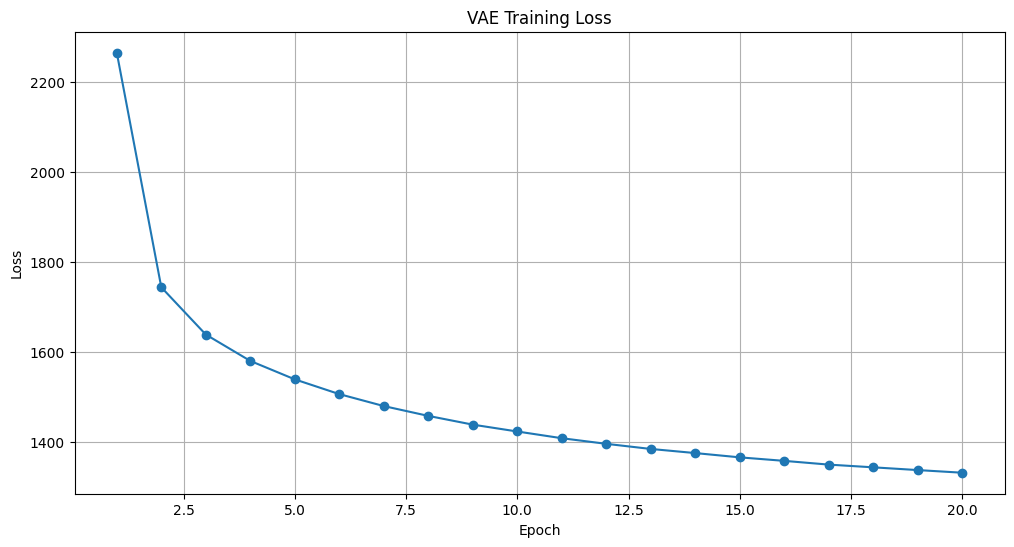

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [79]:
torch.save(model.state_dict(), "vae_ixi_t2_final.pth")

In [24]:
model_vae = VAE(latent_dim=128).to(device)
model_vae.load_state_dict(torch.load("/kaggle/working/vae_ixi_t2_final.pth"))
model_vae.eval()

<ipython-input-24-d691490ab131>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vae.load_state_dict(torch.load("/kaggle/working/vae_ixi_t2_final.pth"))


VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_mu): Linear(in_features=131072, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=131072, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out_features=131072, bias=True)
  (decoder_deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_deconv1): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), strid

In [8]:
class BraTS2020Dataset(Dataset):
    def __init__(self, modality='FLAIR', transform=None, image_size=(256, 256)):
        self.root_dir = sick_training_path
        self.modality = modality
        self.image_size = image_size
        self.folders = sorted([
            os.path.join(self.root_dir, folder)
            for folder in os.listdir(self.root_dir)
            if os.path.isdir(os.path.join(self.root_dir, folder))
        ])
        

    def __len__(self):
        return len(self.folders)
        
    def preprocess_slice(self, slice_data):
        slice_data = slice_data / np.max(slice_data)
        slice_image = Image.fromarray((slice_data * 255).astype(np.uint8)).resize(self.image_size)
        slice_tensor = torch.tensor(np.array(slice_image) / 255.0, dtype=torch.float32).unsqueeze(0)
        return slice_tensor

    def __getitem__(self, idx):
        folder = self.folders[idx]
        folder_name = os.path.basename(folder)

        image_path = os.path.join(folder, f"{folder_name}_{self.modality.lower()}.nii")
        # print(image_path)
        image_data = nib.load(image_path).get_fdata()
        image_slice = image_data[:, :, image_data.shape[2] // 2]
        processed_image = self.preprocess_slice(image_slice)

        mask_path = os.path.join(folder, f"{folder_name}_seg.nii")
        mask_data = nib.load(mask_path).get_fdata()
        mask_slice = mask_data[:, :, mask_data.shape[2] // 2]

        return processed_image.to(device), mask_slice

@torch.no_grad()
def detect_tumor(model, image, threshold=0.1):
    model.eval()
    recon_image, _, _ = model.predict(image.to(device))
    error = torch.abs(image - recon_image).squeeze().cpu().numpy()
    tumor_mask = (error > threshold).astype(np.uint8)
    return error, tumor_mask, recon_image.squeeze().cpu().numpy()

def visualize_detection_with_mask(original_slice, error, tumor_mask, recon_image, real_mask, dice_score, idx):
    
    plt.subplot(5, 5, idx * 5 + 1)
    plt.title(f"Original Slice {idx + 1}")
    plt.imshow(original_slice.T, cmap='gray', origin='lower')
    plt.axis('off')

    plt.subplot(5, 5, idx * 5 + 2)
    plt.title(f"Reconstructed Slice {idx + 1}")
    plt.imshow(recon_image.T, cmap='gray', origin='lower')
    plt.axis('off')

    plt.subplot(5, 5, idx * 5 + 3)
    plt.title(f"Original Tumor Mask {idx + 1}")
    plt.imshow(real_mask.T, cmap='gray', origin='lower')
    plt.axis('off')
    plt.text(0.5, -0.1, f"Dice Score for sample {idx + 1}: {dice_score}", transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')
    
    tumor_mask2 = (tumor_mask > 0).astype(np.float32)
    masked_tumor = np.ma.masked_where(tumor_mask2 == 0, tumor_mask)
    plt.subplot(5, 5, idx * 5 + 4)
    plt.title(f"Predicted Tumor Mask on Slice {idx + 1}")
    plt.imshow(original_slice.T, cmap='gray', origin='lower')
    plt.imshow(masked_tumor.T, cmap='Reds', origin='lower', alpha=0.9, vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(5, 5, idx * 5 + 5)
    plt.title(f"Plain Predicted Tumor Mask {idx + 1}")
    plt.imshow(tumor_mask.T, cmap='gray', origin='lower')
    plt.axis('off')



dataset_vae = BraTS2020Dataset()
test_loader_vae = DataLoader(dataset_vae, batch_size=1, shuffle=False)

Mean Dice Score for all 100 test samples: 0.254778624514882


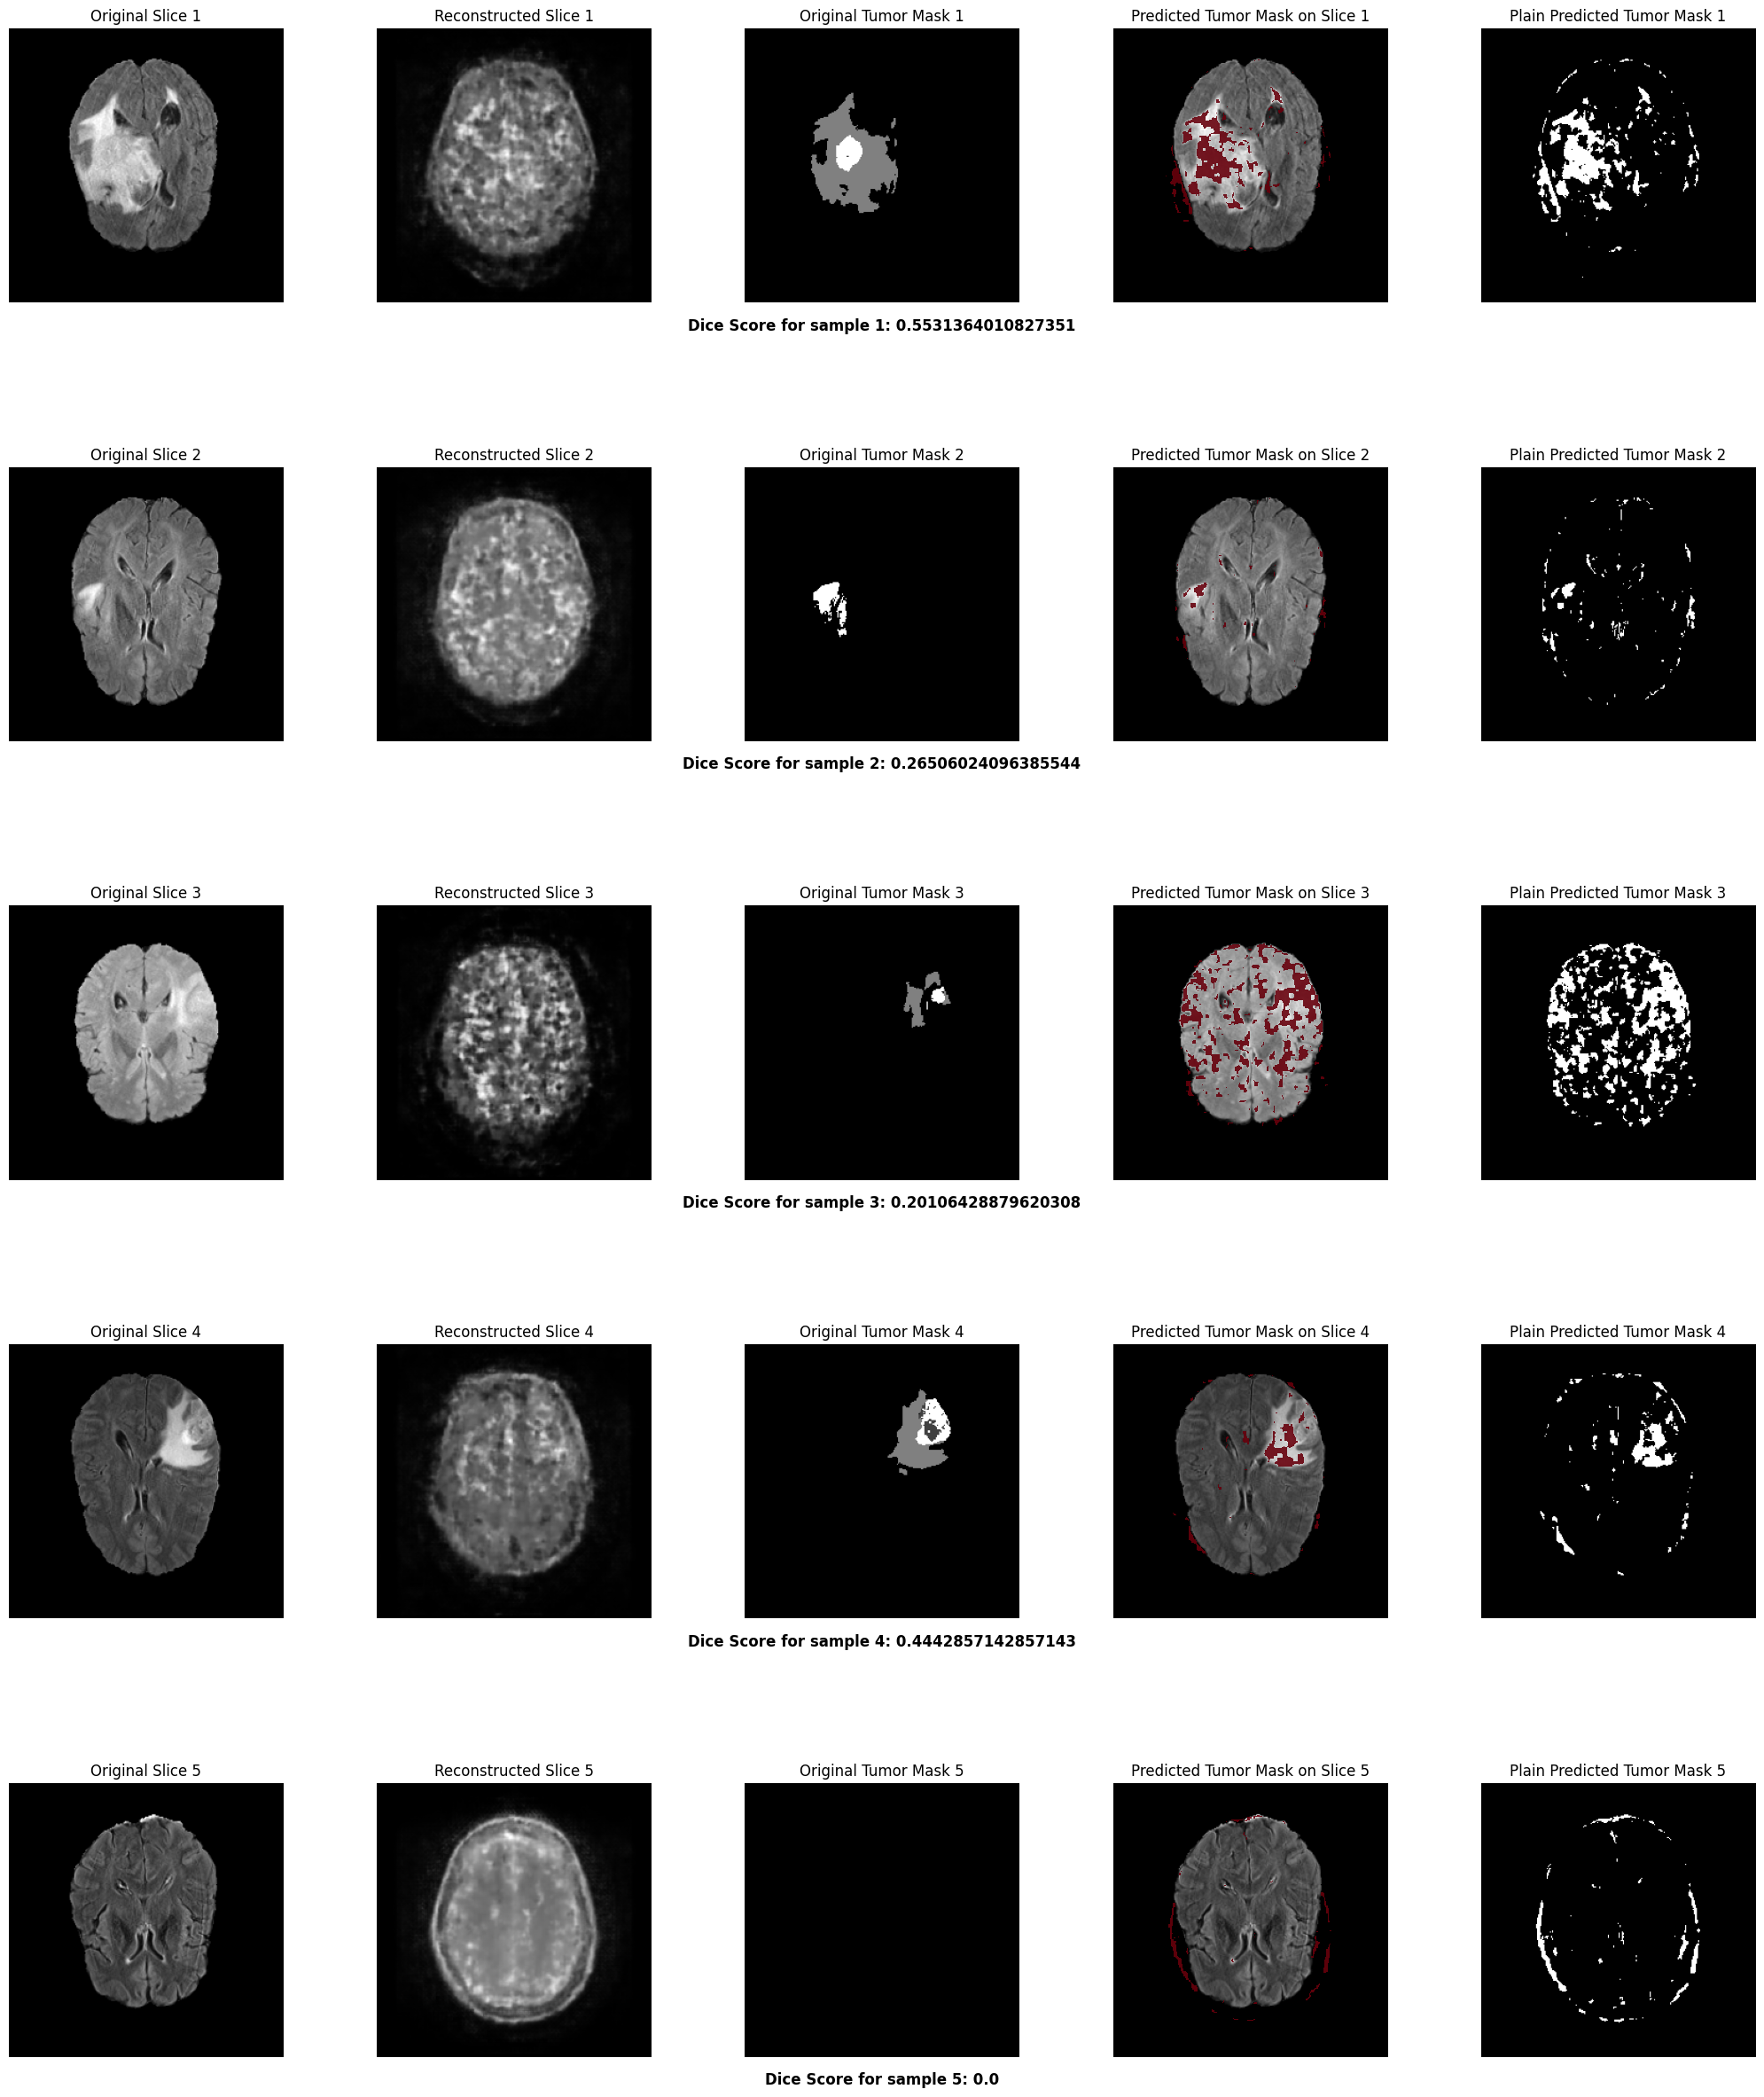

In [25]:
threshold = 0.3
dices_vae = []
plt.figure(figsize=(20, 25))
for idx, (image, real_mask) in enumerate(test_loader_vae):
    if idx > 100:
        break
    real_mask = real_mask.squeeze().cpu().numpy()

    error, tumor_mask, recon_image = detect_tumor(model_vae, image, threshold)
    dice = dice_score(tumor_mask, real_mask)
    dices_vae.append(dice)

    if idx < 5:
        visualize_detection_with_mask(
            original_slice=image.squeeze().cpu().numpy(),
            error=error,
            tumor_mask=tumor_mask,
            recon_image=recon_image,
            real_mask=real_mask,
            dice_score=dice,
            idx=idx
        )

mean_dice = np.mean(dices_vae)
print(f"Mean Dice Score for all 100 test samples: {mean_dice}")

plt.tight_layout()
plt.show()

## Tri-VAE

In [9]:
class IXIT2TripleDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise_type="coarse"):
        self.root_dir = root_dir
        self.transform = transform
        self.noise_type = noise_type
        self.image_paths = [
            os.path.join(root_dir, folder, img)
            for folder in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, folder))
            for img in os.listdir(os.path.join(root_dir, folder))
            if img.endswith(".png")
        ]
        if self.noise_type == "simplex":
            self.simplex = OpenSimplex(seed=random.randint(0, 1000)) 

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor_image = Image.open(anchor_path).convert("L")
        
        positive_idx = random.randint(0, len(self.image_paths) - 1)
        positive_path = self.image_paths[positive_idx]
        positive_image = Image.open(positive_path).convert("L")

        negative_idx = random.randint(0, len(self.image_paths) - 1)
        negative_path = self.image_paths[negative_idx]
        negative_image = Image.open(negative_path).convert("L")

        if self.noise_type == "coarse":
            negative_image = self.add_coarse_noise(negative_image)
        elif self.noise_type == "simplex":
            negative_image = self.add_simplex_noise(negative_image)

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image.to(device), positive_image.to(device), negative_image.to(device)

    def add_coarse_noise(self, image):
        image_np = np.array(image, dtype=np.float32) / 255.0

        noise_resolution = (16, 16)
        coarse_noise = np.random.normal(loc=0.0, scale=0.2, size=noise_resolution)
        upsampled_noise = np.array(Image.fromarray(coarse_noise).resize((256, 256), Image.BILINEAR))
        noisy_image_np = image_np + upsampled_noise
        
        noisy_image_np = np.clip(noisy_image_np, 0, 1)
        noisy_image = Image.fromarray((noisy_image_np * 255).astype(np.uint8))

        return noisy_image
    def add_simplex_noise(self, image):
        image_np = np.array(image, dtype=np.float32) / 255.0
        height, width = image_np.shape

        start_freq = 2 ** -6  # Starting frequency
        octaves = 6           # Number of octaves
        persistence = 0.8     # decay rate
        lacunarity = 2        # Lacunarity (frequency multiplier)

        noise = np.zeros((height, width), dtype=np.float32)
        for i in range(height):
            for j in range(width):
                value = 0
                freq = start_freq
                amp = 1.0
                for _ in range(octaves):
                    value += self.simplex.noise2(i * freq, j * freq) * amp
                    freq *= lacunarity
                    amp *= persistence
                noise[i, j] = value

        noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

        noisy_image_np = image_np + noise
        noisy_image_np = np.clip(noisy_image_np, 0, 1)
        noisy_image = Image.fromarray((noisy_image_np * 255).astype(np.uint8))

        return noisy_image


dataset_coarse = IXIT2TripleDataset(root_dir="/kaggle/input/ixit2-slices/image slice-T2/", transform=transform)
dataloader_coarse = DataLoader(dataset_coarse, batch_size=4, shuffle=True)

dataset_simplex = IXIT2TripleDataset(root_dir="/kaggle/input/ixit2-slices/image slice-T2/", transform=transform, noise_type="simplex")
dataloader_simplex = DataLoader(dataset_simplex, batch_size=4, shuffle=True)

In [10]:
class TriVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(TriVAE, self).__init__()
        # Shared encoder and decoder for Anchor, Positive, and Negative -> Based on the paper
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 256x256 -> 128x128
            nn.ReLU(),
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(),
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 128 * 32 * 32)
        self.decoder_deconv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
        )
        self.decoder_deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
        )
        self.decoder_deconv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 128x128 -> 256x256
            nn.Sigmoid(),
        )
        # Decoder for coarse reconstruction (32x32)
        self.coarse_decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),    # 32x32 -> 32x32
            nn.Sigmoid(),
        )

        # Gated Cross Skip
        self.gcs_linear = nn.Linear(128, 64)
        self.gcs_conv = nn.Conv2d(64, 64, kernel_size=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x1 = self.encoder_conv1(x)
        x2 = self.encoder_conv2(x1)
        x3 = self.encoder_conv3(x2)
        h_flat = self.flatten(x3)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar, x3, x2

    def decode(self, z, skip_x2, skip_x3):
        h_dec = self.fc_dec(z).view(-1, 128, 32, 32)
        h_dec = self.decoder_deconv3(h_dec)

        # GCS integration
        gcs_features = torch.mean(skip_x3, dim=(2, 3))
        gcs_features = self.gcs_linear(gcs_features)
        gcs_features = self.gcs_conv(gcs_features.view(-1, 64, 1, 1))
        h_dec = h_dec + gcs_features

        h_dec = self.decoder_deconv2(h_dec)
        x_recon_full = self.decoder_deconv1(h_dec)

        x_recon_coarse = self.coarse_decoder(skip_x3)

        return x_recon_coarse, x_recon_full

    def forward(self, xa, xp, xn):
        mu_a, logvar_a, skip_a3, skip_a2 = self.encode(xa)
        mu_p, logvar_p, skip_p3, skip_p2 = self.encode(xp)
        mu_n, logvar_n, skip_n3, skip_n2 = self.encode(xn)

        z_a = self.reparameterize(mu_a, logvar_a)
        z_p = self.reparameterize(mu_p, logvar_p)
        z_n = self.reparameterize(mu_n, logvar_n)

        
        x_recon_a_coarse, x_recon_a_full = self.decode(z_a, skip_a2, skip_a3)
        x_recon_p_coarse, x_recon_p_full = self.decode(z_p, skip_p2, skip_p3)
        x_recon_n_coarse, x_recon_n_full = self.decode(z_n, skip_n2, skip_n3)

        return (
            x_recon_a_coarse, x_recon_a_full,
            x_recon_p_coarse, x_recon_p_full,
            x_recon_n_coarse, x_recon_n_full,
            mu_a, logvar_a, mu_p, logvar_p, mu_n, logvar_n
        )
        
    def predict(self, x):
        mu, logvar, skip_x3, skip_x2 = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon_coarse, x_recon_full = self.decode(z, skip_x2, skip_x3)

        return x_recon_full, mu, logvar


def tri_vae_loss(recon_a, xa, xa_coarse, recon_p, xp, xp_coarse, recon_n, xn, xn_coarse, mu_a, logvar_a, mu_p, logvar_p, mu_n, logvar_n):
    # Downsample images for L1 (Coarse) 32*32 -> 16*16
    coarse_size = (16, 16)
    xa_coarse = resize(xa_coarse, coarse_size, antialias=True)
    xp_coarse = resize(xp_coarse, coarse_size, antialias=True)
    xn_coarse = resize(xn_coarse, coarse_size, antialias=True)
    recon_a_coarse = resize(recon_a, coarse_size, antialias=True)
    recon_p_coarse = resize(recon_p, coarse_size, antialias=True)
    recon_n_coarse = resize(recon_n, coarse_size, antialias=True)

    # L1 (Coarse) for Anchor, Positive, Negative
    recon_loss_a_coarse = nn.L1Loss()(recon_a_coarse, xa_coarse)
    recon_loss_p_coarse = nn.L1Loss()(recon_p_coarse, xp_coarse)
    recon_loss_n_coarse = nn.L1Loss()(recon_n_coarse, xn_coarse)
    recon_loss_coarse = recon_loss_a_coarse + recon_loss_p_coarse + recon_loss_n_coarse

    # L1 (Full) for Negative
    recon_loss_n_full = nn.L1Loss()(recon_n, xn)

    # KL Divergence Loss (Anchor and Positive)
    kl_div_a = -0.5 * torch.sum(1 + logvar_a - mu_a.pow(2) - logvar_a.exp()) / xa.size(0)
    kl_div_p = -0.5 * torch.sum(1 + logvar_p - mu_p.pow(2) - logvar_p.exp()) / xp.size(0)
    kl_div_loss = kl_div_a + kl_div_p

    # Triplet Loss
    margin = 1.0
    d_ap = torch.sum((mu_a - mu_p).pow(2), dim=1) 
    d_an = torch.sum((mu_a - mu_n).pow(2), dim=1)
    triplet_loss = torch.mean(F.relu(d_ap - d_an + margin))

    # SSIM Loss (for Negative full reconstruction)
    ssim_loss_fn = SSIM(data_range=1.0, size_average=True, channel=1)
    ssim_loss = 1 - ssim_loss_fn(recon_n, xn)

    total_loss = recon_loss_coarse + recon_loss_n_full + kl_div_loss +  triplet_loss + ssim_loss

    return total_loss

### Coarse

In [153]:
latent_dim = 128
model = TriVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in dataloader_coarse:
        xa, xp, xn = batch  # Anchor, Positive, Negative
        xa, xp, xn = xa.to(device), xp.to(device), xn.to(device)
        optimizer.zero_grad()
        (
            x_recon_a_coarse, x_recon_a_full,
            x_recon_p_coarse, x_recon_p_full,
            x_recon_n_coarse, x_recon_n_full,
            mu_a, logvar_a, mu_p, logvar_p, mu_n, logvar_n
        ) = model(xa, xp, xn)

        loss = tri_vae_loss(x_recon_a_full, xa, x_recon_a_coarse, x_recon_p_full, xp, x_recon_p_coarse, 
                            x_recon_n_full, xn, x_recon_n_coarse, mu_a, logvar_a, mu_p, logvar_p, mu_n, logvar_n)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]}")

Epoch 1/20, Loss: 1.9004121212792036
Epoch 2/20, Loss: 1.8735387235379957
Epoch 3/20, Loss: 1.8728797941982671
Epoch 4/20, Loss: 1.8723247208410834
Epoch 5/20, Loss: 1.8724289698523422
Epoch 6/20, Loss: 1.871719782071158
Epoch 7/20, Loss: 1.8715097575152646
Epoch 8/20, Loss: 1.8717775594902224
Epoch 9/20, Loss: 1.871691915143731
Epoch 10/20, Loss: 1.8716315710807365
Epoch 11/20, Loss: 1.871782951095176
Epoch 12/20, Loss: 1.8720377400201385


KeyboardInterrupt: 

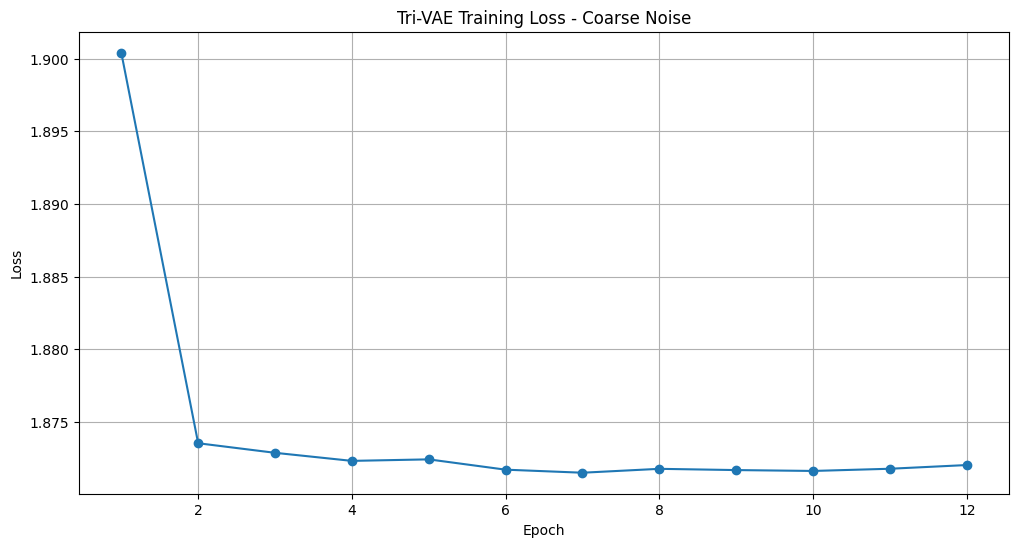

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 12 + 1), train_losses, marker='o')
plt.title("Tri-VAE Training Loss - Coarse Noise")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [189]:
torch.save(model.state_dict(), "tri_vae_coarse_12epoch.pth")

<ipython-input-224-c42bc536731e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_trivae_coarse.load_state_dict(torch.load("tri_vae_coarse_12epoch.pth"))


Mean Dice Score for 100 test samples: 0.4045508069056412


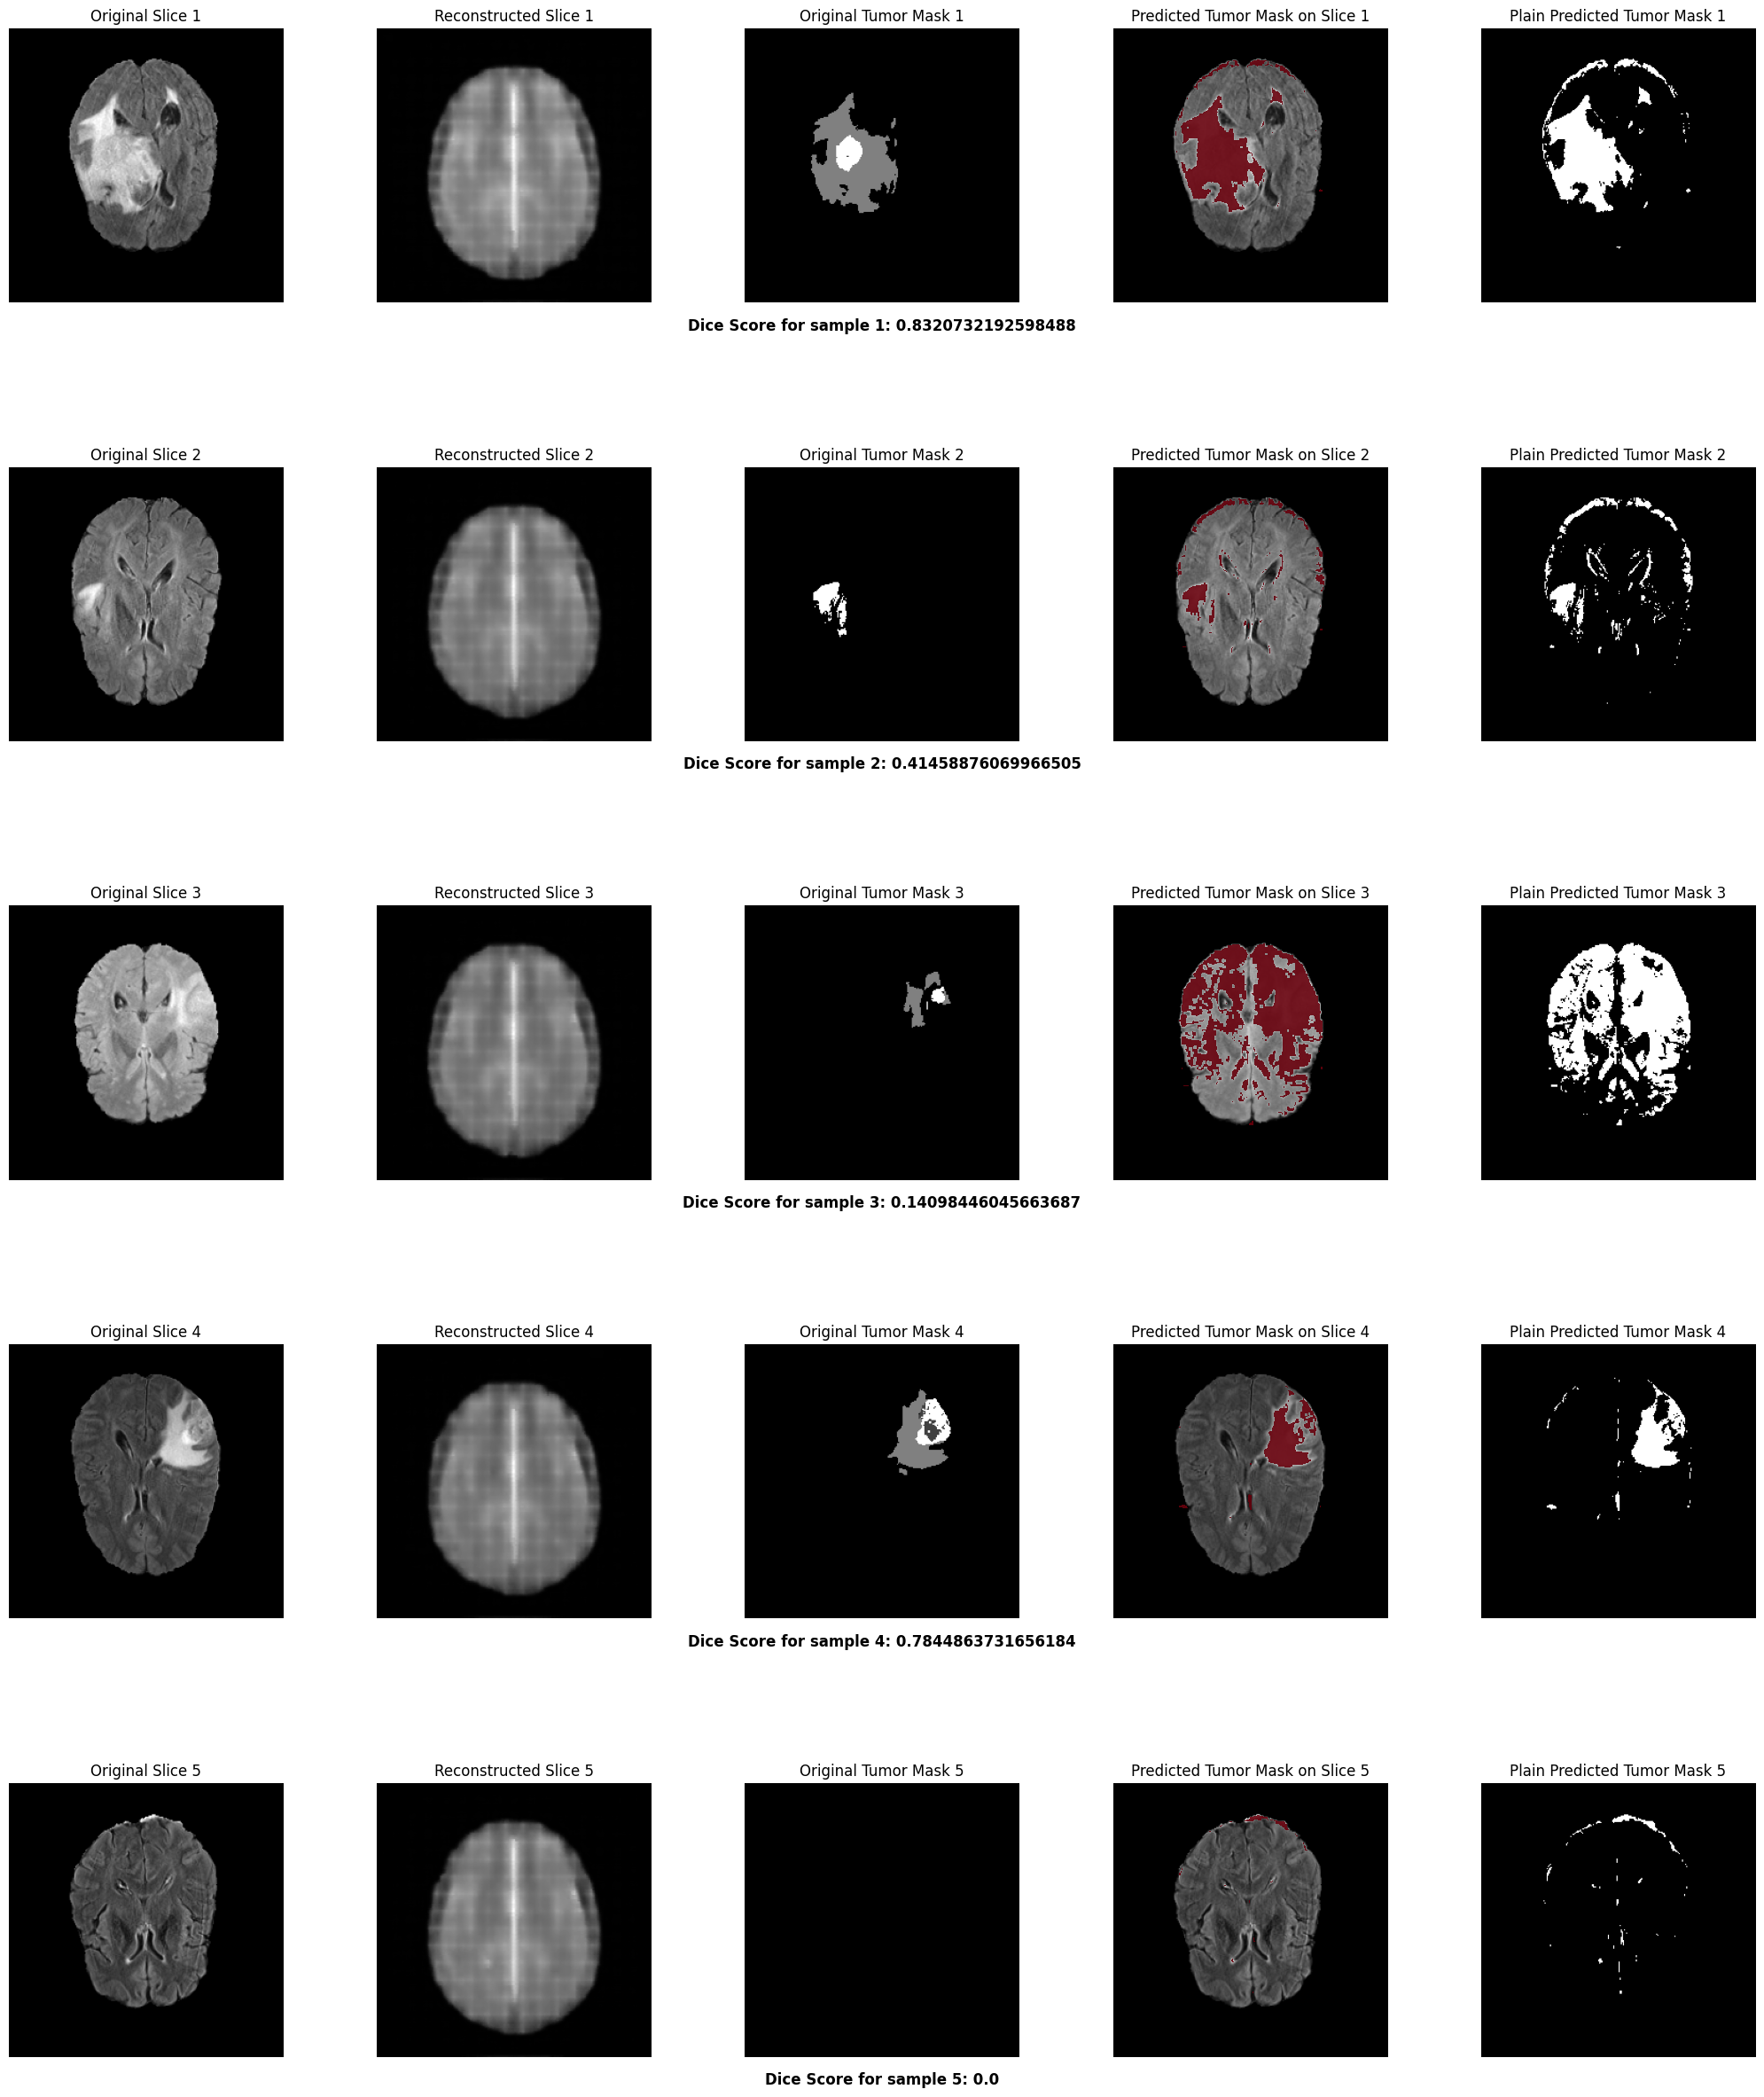

In [224]:
model_trivae_coarse = TriVAE(latent_dim=128)
model_trivae_coarse.load_state_dict(torch.load("tri_vae_coarse_12epoch.pth"))
model_trivae_coarse.to(device)
model_trivae_coarse.eval()

threshold = 0.3
dices_trivae_coarse = []
plt.figure(figsize=(20, 25))
for idx, (image, real_mask) in enumerate(test_loader_vae):
    if idx > 100:
        break
    real_mask = real_mask.squeeze().cpu().numpy()

    error, tumor_mask, recon_image = detect_tumor(model_trivae_coarse, image, threshold)
    dice = dice_score(tumor_mask, real_mask)
    dices_trivae_coarse.append(dice)

    if idx < 5:
        visualize_detection_with_mask(
            original_slice=image.squeeze().cpu().numpy(),
            error=error,
            tumor_mask=tumor_mask,
            recon_image=recon_image,
            real_mask=real_mask,
            dice_score=dice,
            idx=idx
        )

mean_dice = np.mean(dices_trivae_coarse)
print(f"Mean Dice Score for 100 test samples: {mean_dice}")

plt.tight_layout()
plt.show()

### Simplex

In [229]:
print(len(dataloader_simplex))

7213


In [ ]:
latent_dim = 128
model = TriVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

num_epochs = 20
train_losses_simplex = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in dataloader_simplex:
        # print("here?")
        xa, xp, xn = batch  # Anchor, Positive, Negative
        xa, xp, xn = xa.to(device), xp.to(device), xn.to(device)
        optimizer.zero_grad()
        (
            x_recon_a_coarse, x_recon_a_full,
            x_recon_p_coarse, x_recon_p_full,
            x_recon_n_coarse, x_recon_n_full,
            mu_a, logvar_a, mu_p, logvar_p, mu_n, logvar_n
        ) = model(xa, xp, xn)

        loss = tri_vae_loss(x_recon_a_full, xa, x_recon_a_coarse, x_recon_p_full, xp, x_recon_p_coarse, 
                            x_recon_n_full, xn, x_recon_n_coarse, mu_a, logvar_a, mu_p, logvar_p, mu_n, logvar_n)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    train_losses_simplex.append(epoch_loss / len(dataloader_simplex))
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses_simplex[-1]}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 12 + 1), train_losses, marker='o')
plt.title("Tri-VAE Training Loss - Simplex Noise")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

0.2776341438293457


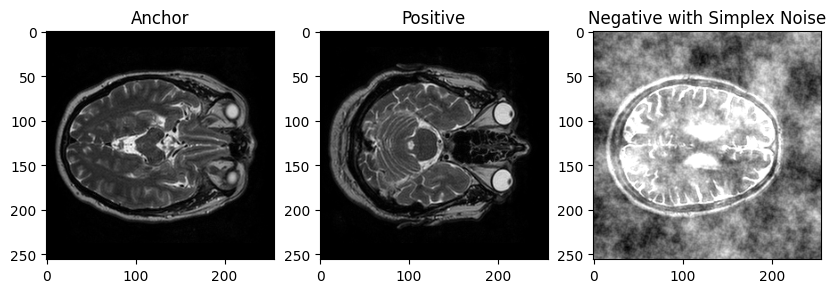

In [18]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = IXIT2TripleDataset(root_dir=base_healthy_path, transform=transform, noise_type="simplex")

import time
s = time.time()
anchor, positive, negative = dataset[13]
e = time.time()

print(e - s)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Anchor")
plt.imshow(anchor.squeeze().cpu().numpy(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Positive")
plt.imshow(positive.squeeze().cpu().numpy(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Negative with Simplex Noise")
plt.imshow(negative.squeeze().cpu().numpy(), cmap="gray")

plt.show()

0.01483464241027832


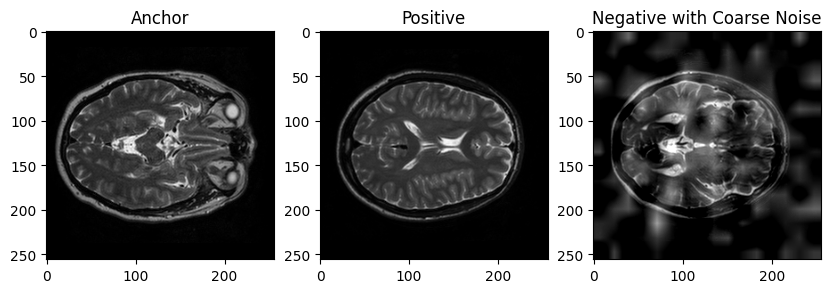

In [22]:
dataset = IXIT2TripleDataset(root_dir=base_healthy_path, transform=transform, noise_type="coarse")
s = time.time()
anchor, positive, negative = dataset[13]
e = time.time()

print(e - s)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Anchor")
plt.imshow(anchor.squeeze().cpu().numpy(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Positive")
plt.imshow(positive.squeeze().cpu().numpy(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Negative with Coarse Noise")
plt.imshow(negative.squeeze().cpu().numpy(), cmap="gray")

plt.show()